# Modelo de classificação kNN
Neste arquivo vamos criar um modelo kNN e otimizar seus hiperparâmetros para fazer previsões do estado de saúde dos pacientes a partir de seus biomarcadores. O dataframe escolhido para este estudo tem uma coluna denominada Class, que guarda o estado do indivíduo, entre Control e Impaired. Os indivíduos classificados como Control são indivíduos de controle saudáveis, enquanto Impaired são indivíduos afetados por Alzheimer.

In [29]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
# Importando dados
features = pd.read_csv("Features para trino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
features = features.values

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1)
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [3]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

In [19]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="recall",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_log_reg(trial):
    parametros = {'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
                  'penalty': trial.suggest_categorical('penalty', ["l2"]),
                  'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', "liblinear"]),
                  'max_iter': trial.suggest_int('max_iter', 100, 10000)}
    return objetivo_geral(trial, parametros, LogisticRegression)

In [20]:
NOME_DO_ESTUDO = "log_reg4"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_log_reg, n_trials=1000)

[I 2025-11-01 16:27:24,856] A new study created in RDB with name: log_reg4
[I 2025-11-01 16:27:25,056] Trial 0 finished with value: 0.0 and parameters: {'C': 8.336019762416839e-05, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 4692}. Best is trial 0 with value: 0.0.
[I 2025-11-01 16:27:25,149] Trial 1 finished with value: 0.1901098901098901 and parameters: {'C': 0.0014916983337217222, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 4477}. Best is trial 1 with value: 0.1901098901098901.
[I 2025-11-01 16:27:26,674] Trial 2 finished with value: 0.6780219780219781 and parameters: {'C': 0.10123571451224243, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 9416}. Best is trial 2 with value: 0.6780219780219781.
[I 2025-11-01 16:27:26,972] Trial 3 finished with value: 0.12967032967032965 and parameters: {'C': 0.0006155200420783658, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 9707}. Best is trial 2 with value: 0.6780219780219781.
C:\Users\vitor25023\AppData\Roaming\Python\Python312\sit

In [ ]:
# Treinando um modelo regressão logística com estes parâmetros
params = estudo_knn.best_trial.params
params["max_iter"] = 10000
# Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = LogisticRegression(**params)
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="recall",
    cv = 5,
    n_jobs=-1
)
seletor.fit(features, target)

X_treino_modificado = seletor.transform(features)
X_teste_modificado = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")

predictor = LogisticRegression(**params)
predictor.fit(X_treino_modificado, target)

C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [ True False False False False False  True  True False False False  True
 False False False False False False False False  True False False  True
 False False  True False False False False  True False  True False False
 False False False  True False  True  True False False  True False False
 False False False False  True False False False  True False False False
  True False False False False  True False False False False False False
  True False  True False  True False  True  True  True  True  True False
  True  True  True False  True False False  True  True  True False  True
  True False  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True]


,penalty,'l2'
,dual,False
,tol,0.0001
,C,15.966515703078324
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [26]:
predictor = LogisticRegression(**params)
predictor.fit(X_treino_modificado, target)
y_pred = predictor.predict(X_teste_modificado)
accuracy = accuracy_score(y_teste, y_pred)
print(accuracy)

y_pred_trans = le.inverse_transform(y_pred)

medida = cross_val_score(predictor, X_teste_modificado, y_teste, scoring="recall", cv=5)
print("Recall médio no conjunto de teste:", medida.mean())

0.7857142857142857
Recall médio no conjunto de teste: 0.73


['Control' 'Impaired']


<Axes: >

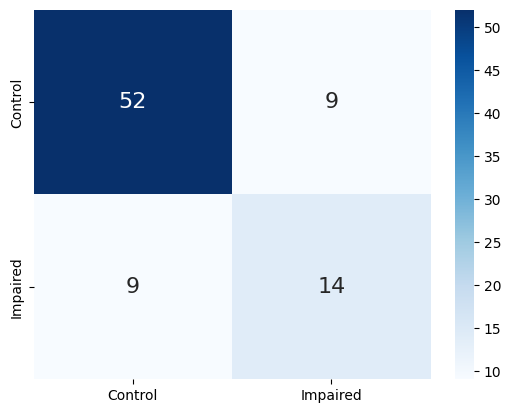

In [28]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [30]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.85      0.85      0.85        61
    Impaired       0.61      0.61      0.61        23

    accuracy                           0.79        84
   macro avg       0.73      0.73      0.73        84
weighted avg       0.79      0.79      0.79        84



## Conclusões:
Nosso modelo apresenta grande viés para classificar indivíduos como saudáveis. Apesar de ter acertado a maioria dos indivíduos saudáveis, classificou a maior parte dos doentes como saudáveis, apresentando um falso negativo muito forte. Isso pode acontecer porque o modelo k-NN é suscetível à qualidade dos vizinhos, e como em nossos dados de treino, a quantidade de indivíduos saudáveis é maior que a de doentes, muito provavelmente, nosso modelo foi enviezado para esta categoria. A razão entre a quantidade de acertos na previsão de pessoas doentes e a quantidade real de pessoas doentes é menor que um terço, o que torna nosso modelo insatisfatório.